In [1]:
import random

In [42]:
from qibo import hamiltonians
from qibo.symbols import Z
import numpy as np

def TCP(dose, D50=40, a=0.2):
    return 1 / (1 + np.exp(-a * (dose - D50)))

def NTCP(dose, dose_rate, D_crit=40, R_crit=40, epsilon=0.5):
    flash_correction = 1 + epsilon * (R_crit / dose_rate)
    return (dose / D_crit) * flash_correction

def build_cost_hamiltonian(doses, dose_rates, depths,
                            alpha=1.0, beta=10.0, 
                            gamma=1000.0,
                            lambda_depth=0.3,
                            session_cost_flash=20.0,
                            flash_threshold=40,
                            depth_limit=12,
                            flash_incompatibility_penalty=5000,
                            ntcp_gain_threshold=0.1,    # <-- new: minimum gain needed to justify FLASH
                            artificial_nonflash_rate=1):  # <-- new: to simulate non-FLASH NTCP
    """
    Build the full cost Hamiltonian with smart FLASH decision logic.
    """
    n = len(doses)
    cost = 0
    
    for i in range(n):

        dose_i = doses[i]
        rate_i = dose_rates[i]
        depth_i = depths[i]

        tcp = TCP(dose_i)
        # ntcp_flash = NTCP(dose_i, rate_i)
        # ntcp_nonflash = NTCP(dose_i, artificial_nonflash_rate)

        # ntcp_gain = ntcp_nonflash - ntcp_flash
        # print(ntcp_gain)

        # cost += lambda_depth * depth_i * (1 - Z(i))

        # Always: reward TCP and penalize NTCP (depending on FLASH or non-FLASH)
        if rate_i > flash_threshold:
            ntcp_flash = NTCP(dose_i, rate_i)
            ntcp_nonflash = NTCP(dose_i, artificial_nonflash_rate)

            ntcp_gain = ntcp_nonflash - ntcp_flash
            print(ntcp_gain)
            print(i)
            if ntcp_gain >= 0.1:
                # FLASH is justified: use FLASH NTCP and pay session cost
                # cost += (-alpha * tcp + beta * ntcp_flash) * (1 - Z(i))
                cost += session_cost_flash
            else:
                # FLASH NOT justified: add big penalty
                cost += flash_incompatibility_penalty
        else:
            # Conventional beam: use non-FLASH NTCP
            # cost += (-alpha * tcp + beta * ntcp_nonflash) * (1 - Z(i))
            cost += flash_incompatibility_penalty
            
            # Single beam constraint
        constraint = 0
        for i in range(n):
            constraint += -(1 - Z(i))
        for i in range(n):
            for j in range(i+1, n):
                constraint += 2 * (1 - Z(i)) * (1 - Z(j))
        constraint += 1  # Constant

        cost += gamma * constraint

    return hamiltonians.SymbolicHamiltonian(cost)



In [47]:
doses = [50, 20, 25, 30, 35]          # Gy
dose_rates = [40,40,40,40,40]    # Gy/s (only beams 1, 2, 3 are FLASH!)
depths = [4, 3, 5, 1, 13]              # cm (all shallow <12 cm)


cost_hamiltonian = build_cost_hamiltonian(doses, dose_rates, depths)

In [48]:
import numpy as np
from qibo import set_backend

# set the backend used for the calculation 
set_backend("numpy", platform=None)


# # create the cost Hamiltonian for the given graph
# cost_hamiltonian = build_cost_hamiltonian(initial_params, doses, tcp_params, ntcp_params, penalty_terms)

ham_matrix = cost_hamiltonian.matrix

eig_val, eig_vec = np.linalg.eig(ham_matrix)
eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=len(doses)) for i in eig_vec]

vec = zip(eig_val, eig_vec)
diagonalized_solution = sorted(vec, key=lambda x: x[0])

print(diagonalized_solution)
print("Optimal solution: ", diagonalized_solution[0][1])

[Qibo 0.2.18|INFO|2025-04-26 20:48:19]: Using numpy backend on /CPU:0
[Qibo 0.2.18|WARNING|2025-04-26 20:48:19]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[(np.complex128(20000+0j), '00001'), (np.complex128(20000+0j), '00010'), (np.complex128(20000+0j), '00100'), (np.complex128(20000+0j), '01000'), (np.complex128(20000+0j), '10000'), (np.complex128(30000+0j), '00000'), (np.complex128(50000+0j), '00011'), (np.complex128(50000+0j), '00101'), (np.complex128(50000+0j), '00110'), (np.complex128(50000+0j), '01001'), (np.complex128(50000+0j), '01010'), (np.complex128(50000+0j), '01100'), (np.complex128(50000+0j), '10001'), (np.complex128(50000+0j), '10010'), (np.complex128(50000+0j), '10100'), (np.complex128(50000+0j), '11000'), (np.complex128(120000+0j), '00111'), (np.complex128(120000+0j), '01011'), (np.complex128(120000+0j), '01101'), (np.complex128(120000+0j), '01110'), (np.complex128(120000+0j), '10011'), (np.complex128(120000+0j), '10101'), (np.complex128(120000+0j), '10110'), (np.complex128(120000+0j), '11001'), (np.complex128(120000+0j), '11010'), (np.complex128(120000+0j), '11100'), (np.complex128(230000+0j), '01111'), (np.complex128(2

In [5]:
from qibo.symbols import Z, X, Y
from qibo.hamiltonians import SymbolicHamiltonian
import numpy as np

def build_mixer_hamiltonian(nqubits: int) -> SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    # create the mixer Hamiltonian
    mixing_hamiltonian = sum((Y(i)) for i in range(nqubits))
    return SymbolicHamiltonian(mixing_hamiltonian)

In [6]:
from qibo import models

hamiltonian = build_cost_hamiltonian(doses, dose_rates, depths)
mixer_hamiltonian = build_mixer_hamiltonian(nqubits=len(doses))

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with four layers 
n_layers = 3
# initial_parameters = 0.01 * np.random.random(n_layers * 2)
initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi
print(initial_parameters)

"""
supported optimization Method: 
- Nelder-Mead 
- parallel_L-BFGS-B
- Powell
- CG
- cma
- sgd
- L-BFGS-B
- Newton-CG
- COBYLA
- BFGS
- trust-constr
"""
method = "COBYLA"


best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)

print("best energy: ", best_energy)

[ 0.00063954  0.03084361 -0.00944103  0.01178451 -0.01769863 -0.02248606]


best energy:  256893.79039140145


[('36.94 %', '11111'), ('10.23 %', '01111'), ('8.21 %', '11101'), ('8.08 %', '11011'), ('7.76 %', '10111'), ('7.18 %', '11110'), ('2.17 %', '01101'), ('2.14 %', '01011'), ('2.05 %', '00111'), ('1.90 %', '01110'), ('1.71 %', '11001'), ('1.64 %', '10101'), ('1.62 %', '10011'), ('1.52 %', '11100'), ('1.49 %', '11010'), ('1.43 %', '10110'), ('0.43 %', '01001'), ('0.41 %', '00101'), ('0.41 %', '00011'), ('0.38 %', '01100'), ('0.38 %', '01010'), ('0.36 %', '00110'), ('0.32 %', '10001'), ('0.30 %', '11000'), ('0.29 %', '10100'), ('0.28 %', '10010'), ('0.08 %', '00001'), ('0.07 %', '01000'), ('0.07 %', '00100'), ('0.07 %', '00010'), ('0.05 %', '10000'), ('0.01 %', '00000')]
The best solution is: 11111
----------
[('15.77 %', '11000'), ('8.46 %', '10000'), ('7.42 %', '00111'), ('6.45 %', '10001'), ('6.22 %', '01000'), ('5.96 %', '10111'), ('5.45 %', '01111'), ('5.32 %', '10011'), ('3.66 %', '10100'), ('3.37 %', '11001'), ('3.24 %', '10010'), ('2.75 %', '01100'), ('2.64 %', '00011'), ('2.64 %', 

Text(0, 0.5, 'Ground energy')

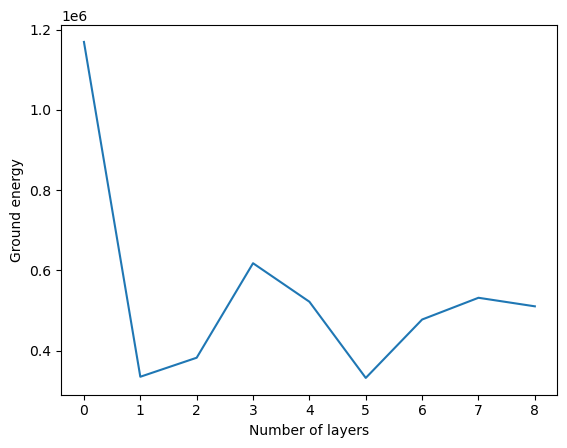

In [7]:
import matplotlib.pyplot as plt
nqubits = len(doses)

hamiltonian = build_cost_hamiltonian(doses, dose_rates, depths)
mixer_hamiltonian = build_mixer_hamiltonian(nqubits=len(doses))

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

method = "COBYLA"
    
ground_energy = []
ground_state = []
for n_layers in range(1,10):
    initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi
    best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)
    #print("initial_parameters",initial_parameters)
    #print("best energy: ", best_energy)
    ground_energy.append(best_energy)
    
    qaoa.set_parameters(final_parameters)
    quantum_state = qaoa.execute(None)

    probabilities = (np.abs(quantum_state) ** 2)
    probabilities = zip(probabilities, [i for i in range(len(probabilities))])
    probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
    probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
    print(probabilities)
    qaoa_solution = probabilities[0][1]
    print("The best solution is:", qaoa_solution )
    print("-"*10)

plt.plot(ground_energy)
plt.xlabel('Number of layers')
plt.ylabel('Ground energy')

In [8]:
def beam_cost(i, doses, dose_rates, depths,
              alpha=1.0, beta=10.0, 
              lambda_depth=0.5, session_cost_flash=20,
              flash_threshold=40, depth_limit=12,
              flash_incompatibility_penalty=5000,
              ntcp_gain_threshold=0.1,
              artificial_nonflash_rate=1):
    """
    Calculates the full cost of using beam i,
    and compares NTCP between FLASH and non-FLASH delivery.
    """
    dose = doses[i]
    dose_rate = dose_rates[i]
    depth = depths[i]
    
    tcp = TCP(dose)
    ntcp_flash = NTCP(dose, dose_rate)  # FLASH case (real rate)
    ntcp_nonflash = NTCP(dose, artificial_nonflash_rate)  # simulate conventional
    
    ntcp_gain = ntcp_nonflash - ntcp_flash  # how much normal tissue saved

    return tcp, ntcp_flash, ntcp_nonflash, ntcp_gain


In [9]:
doses = [15, 20, 25, 30, 35]          # Gy
dose_rates = [0.3, 45, 50, 80, 0.3]    # Gy/s (only beams 1, 2, 3 are FLASH!)
depths = [3, 4, 5, 6, 7]              # cm (all shallow <12 cm)


for i in range(len(doses)):
    tcp, ntcp_flash, ntcp_nonflash, ntcp_gain = beam_cost(i, doses, dose_rates, depths)
    print(f"   TCP = {tcp:.3f}")
    print(f"   NTCP (FLASH) = {ntcp_flash:.3f}")
    print(f"   NTCP (Conventional) = {ntcp_nonflash:.3f}")
    print(f"   NTCP Gain = {ntcp_gain:.3f}")
    print("")


   TCP = 0.007
   NTCP (FLASH) = 25.375
   NTCP (Conventional) = 7.875
   NTCP Gain = -17.500

   TCP = 0.018
   NTCP (FLASH) = 0.722
   NTCP (Conventional) = 10.500
   NTCP Gain = 9.778

   TCP = 0.047
   NTCP (FLASH) = 0.875
   NTCP (Conventional) = 13.125
   NTCP Gain = 12.250

   TCP = 0.119
   NTCP (FLASH) = 0.938
   NTCP (Conventional) = 15.750
   NTCP Gain = 14.812

   TCP = 0.269
   NTCP (FLASH) = 59.208
   NTCP (Conventional) = 18.375
   NTCP Gain = -40.833

